Wave Analysis

Import Libraries

In [1]:
from mne.preprocessing.nirs import optical_density
from itertools import compress

import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

# Import MNE processing
import mne
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne_nirs
from mne_nirs.channels import get_long_channels, get_short_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import (enhance_negative_correlation,
                                         short_channel_regression)

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import lets_plot
from lets_plot import *

# Imports libraries related to GLM Ananlysis
import h5py
from scipy import interpolate
import numpy as np
from mne_nirs.experimental_design import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from mne_nirs.statistics import run_glm
from mne import read_evokeds



Import Data and make Conversions

In [2]:
# fname = r"C:\Users\dalto\Downloads\sourcedata\sub-05\ses-01\nirs\sub-05_ses-01.snirf"

# raw_intensity = mne.io.read_raw_snirf(
#     fname, preload=True, optode_frame="mri"
# )  # reads snirf file and stores into 'raw' data type

# raw_intensity.resample(0.7)  # resample the raw intensity data at 0.7 Hz

# raw_od = optical_density(
#     raw_intensity
# )  # converts nirs 'raw' data into 'raw' optical density data


# condition = "Meaningful"
leg_list = ["Oxyhaemoglobin", "Oxyhaemoglobin Range","Start of Epoch","Deoxyhaemoglobin","Deoxyhaemoglobin Range"]  #stores values to go in waveform analysis legend
# cond_list = ["Control", "Anomalous", "Meaningful"]  # list of the potential conditions


Establish function to perform analysis on each data point after the trigger

In [3]:
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = mne.io.read_raw_snirf(
        fname=bids_path, verbose=False, optode_frame="mri"
    )

    # Rename annotations
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '15')
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '1')
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '2')# Delete unwanted annotation

     #######################################################
    #  Rename conditions below to match your conditions   #
    #######################################################
    
    raw_intensity.annotations.rename({'101': 'ee', 
                                      '102': 'ee',
                                      '103': 'ee',
                                      '104': 'ee',
                                      '105': 'ee',
                                      '106': 'ee',
                                      '107': 'ee',
                                      '108': 'ee',
                                      '109': 'ee',
                                      '110': 'ee',
                                      '111': 'ee',
                                      '112': 'ee',
                                      '113': 'ee',
                                      '114': 'ee',
                                      '115': 'ee',
                                      '116': 'ii',
                                      '117': 'ii',
                                      '118': 'ii',
                                      '119': 'ii',
                                      '120': 'ii',
                                      '121': 'ii',
                                      '122': 'ii',
                                      '123': 'ii',
                                      '124': 'ii',
                                      '125': 'ii',
                                      '126': 'ii',
                                      '127': 'ii',
                                      '128': 'ii',
                                      '129': 'ii',
                                      '130': 'ii', 
                                      '131': 'ei',
                                      '132': 'ei',
                                      '133': 'ei',
                                      '134': 'ei',
                                      '135': 'ei',
                                      '136': 'ei',
                                      '137': 'ei',
                                      '138': 'ei',
                                      '139': 'ei',
                                      '140': 'ei',
                                      '141': 'ie',
                                      '142': 'ie',
                                      '143': 'ie',
                                      '144': 'ie',
                                      '145': 'ie',
                                      '146': 'ie',
                                      '147': 'ie',
                                      '148': 'ie',
                                      '149': 'ie',
                                      '150': 'ie',
                                      '11': 'ee-q', 
                                      '12': 'ii-q', 
                                      '13': 'ei-q', 
                                      '14': 'ie-q'})
        
      # Rename annotations to meaningful labels
   # raw_intensity.annotations.rename(
        #{'Meaningful6': 'Button'}
   # )  # Correct a specific annotation label

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)  # Convert intensity data to optical density
    sci = scalp_coupling_index(
        raw_od, h_freq=1.35, h_trans_bandwidth=0.1
    )  # Calculate scalp coupling index
    raw_od.info["bads"] = list(
        compress(raw_od.ch_names, sci < 0.7)
    )  # Identify and mark channels with poor scalp coupling
    raw_od.interpolate_bads()  # Interpolate bad channels

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)  # Downsample the data
    raw_od = temporal_derivative_distribution_repair(
        raw_od
    )  # Apply temporal derivative distribution repair
    raw_od = short_channel_regression(
        raw_od
    )  # Perform short channel subtraction

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(
        raw_od, ppf=.1
    )  # Apply the Beer-Lambert Law to convert to haemoglobin
    raw_haemo = raw_haemo.filter(
        0.02, 0.3, h_trans_bandwidth=0.1, l_trans_bandwidth=0.01, verbose=False
    )  # Apply bandpass filtering

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = get_long_channels(
        raw_haemo, min_dist=0.015, max_dist=0.045
    )  # Filter out short channels
    events, event_dict = mne.events_from_annotations(
        raw_haemo, verbose=False
    )  # Extract events and create event dictionary
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        event_repeated= "drop",
        ###########################  MODIFY THIS FOR EACH EXPERIMENT #############################
        tmin=-3,  # Set the minimum time before the onset of the signal for each epoch
        tmax=25,  # Set the maximum time after the onset of the signal for each epoch
        ########################################  END  ###########################################
        reject=dict(hbo=100e-6),  # Set the peak-to-peak amplitude rejection criteria per epoch
        reject_by_annotation=True,  # Reject epochs based on annotations
        proj=False,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=True
    )  # Create epochs

    return raw_haemo, epochs


Evoked Response Analysis for Multiple Subjects

In [4]:
all_evokeds = defaultdict(list)

#for sub in range(2, 6):  # change range values to specify the number of subject recordings to be analyzed
for sub in [53, 54, 55, 56, 58, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]:     
    bids_path = BIDSPath(subject="H%03d" % sub ,
                         session="02", 
                         datatype="nirs",
                         root= r"/Users/coletrent/Library/CloudStorage/Box-Box/BRAiN Lab/current projects/elliptical-speech-project/nirs data/4ch-16ch-same-different-naive-listeners/sourcedata",
                         extension= ".snirf")

    
    # Analyse data and return both ROI and channel results
    raw_haemo, epochs = individual_analysis(bids_path)

    # Save individual-evoked participant data along with others in all_evokeds
    for cidx, condition in enumerate(epochs.event_id):
        all_evokeds[condition].append(epochs[condition].average())


Reading 0 ... 9735  =      0.000 ...  1913.901 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S14_D12 hbo']
1 bad epochs dropped
Reading 0 ... 9661  =      0.000 ...  1899.353 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


1 bad epochs dropped
Reading 0 ... 10130  =      0.000 ...  1991.558 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S1

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S3_D11 hbo', 'S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo', 'S14_D15 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo', 'S14_D15 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_D10 hbo']
    Rejecting  epoch based on HBO : ['S12_

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


1 bad epochs dropped
Reading 0 ... 9833  =      0.000 ...  1933.168 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
1 bad epochs dropped


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()  # Interpolate bad channels


Reading 0 ... 9312  =      0.000 ...  1830.739 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S10_D9 hbo']
    Rejecting  epoch based on HBO : ['S10_D9 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


4 bad epochs dropped
Reading 0 ... 9689  =      0.000 ...  1904.857 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S4_D11 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo', 'S8_D6 hbo', 'S13_D12 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D12 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D12 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo', 'S13_D13 hbo']
    Rejecting  epo

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S14_D14 hbo', 'S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo']
    Rejecting  epoch based on HBO : ['S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo']
17 bad epochs dropped
Reading 0 ... 9626  =      0.000 ...  1892.472 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S6_D6 hbo']
    Rejecting  epoch based on HBO : ['S6_D6 hbo']
    Rejecting  epoch based on HBO : ['S6_D6 hbo']
    Rejecting  epoch based on HBO : [

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


6 bad epochs dropped
Reading 0 ... 9722  =      0.000 ...  1911.345 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D10 hbo', 'S8_D7 hbo', 'S13_D13 hbo', 'S15_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D10 hbo', 'S8_D7 hbo', 'S12_D10 hbo', 'S15_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S3_D10 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S3_D10 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S15_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S8_D6 hbo', 'S15

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S3_D10 hbo', 'S8_D6 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S7_D7 hbo', 'S12_D10 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S7_D5 hbo', 'S7_D7 hbo', 'S12_D10 hbo', 'S14_D13 hbo', 'S14_D14 hbo', 'S16_D14 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D10 hbo', 'S8_D6 hbo', 'S12_D10 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D10 hbo', 'S8_D6 hbo', 'S12_D10 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S15_D15 hbo']
49 bad epochs dropped
Reading 0 ... 9683  =      0.000 ...  1903.678 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
1 bad epochs dropped


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()  # Interpolate bad channels


Reading 0 ... 9535  =      0.000 ...  1874.581 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch base

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']
32 bad epochs dropped
Reading 0 ... 9503  =      0.000 ...  1868.290 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S3_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D11 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S2_D3 hbo']
    Rejecting  epoch based on HBO : ['S2_D3 hbo']
9 bad epochs dropped
Reading 0 ... 12913  =      0.000 ...  2538.696 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo']
18 bad epochs dropped
Reading 0 ... 9654  =      0.000 ...  1897.976 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S3_D11 hbo']
2 bad epochs dropped


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


Reading 0 ... 9716  =      0.000 ...  1910.166 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
1 bad epochs dropped


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


Reading 0 ... 9590  =      0.000 ...  1885.394 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S13_D12 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D12 hbo']
    Rejecting  epoch based on HBO : ['S13_D12 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D12 hbo', 'S13_D13 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


5 bad epochs dropped
Reading 0 ... 9721  =      0.000 ...  1911.149 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S14_D12 hbo']
    Rejecting  epoch based on HBO : ['S14_D12 hbo']
    Rejecting  epoch based on HBO : ['S14_D12 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S14_D12 hbo', 'S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S14_D12 hbo', 'S14_D15 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S14_D12 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S14_D15 hbo']
    Rejecting  epoch based on HBO : ['S14_D14 hbo']
10 bad epochs dropped
Reading 0 ... 9564  =      0.000 ...  1880.282 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S1_D3 hbo']
    Rejecting  epoch based on HBO : ['S1_D3 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S13_D13 hbo', 'S15_D15 hbo']
8 bad epochs dropped
Reading 0 ... 9668  =      0.000 ...  1900.729 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S16_D14 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S5_D5 hbo']
3 bad epochs dropped
Reading 0 ... 9607  =      0.000 ...  1888.736 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo']
    Rejecting  epoch based on HBO : ['S6_D7 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S6_D7 hbo']
    Reject

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S10_D10 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
15 bad epochs dropped
Reading 0 ... 9792  =      0.000 ...  1925.107 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S11_D9 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S11_D9 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo']


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


6 bad epochs dropped
Reading 0 ... 9751  =      0.000 ...  1917.047 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S2_D3 hbo']
    Rejecting  epoch based on HBO : ['S2_D3 hbo', 'S3_D3 hbo', 'S3_D10 hbo', 'S4_D11 hbo', 'S6_D7 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S9_D8 hbo', 'S11_D10 hbo', 'S14_D12 hbo', 'S14_D14 hbo', 'S14_D15 hbo', 'S15_D13 hbo', 'S15_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S3_D3 hbo', 'S4_D11 hbo', 'S7_D5 hbo', 'S14_D12 hbo', 'S14_D15 hbo', 'S15_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo', 'S12_D11 hbo', 'S14_D12 hbo', 'S14_D15 hbo', 'S16_D15 hbo']
    Rejecting  epoch based on HBO : ['S1_D2 hbo', 'S1_D3 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D10 hbo', 'S4_D11 hbo', 'S6_D4 hbo', 'S6_D7 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S9_D8 hbo', 'S10_D10 hbo', 'S11_D10 hbo', 'S14_D12 hbo', 'S14_D14 hbo', 'S

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S10_D9 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
    Rejecting  epoch based on HBO : ['S15_D13 hbo']
24 bad epochs dropped
Reading 0 ... 9573  =      0.000 ...  1882.052 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
  

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S11_D10 hbo']
    Rejecting  epoch based on HBO : ['S11_D10 hbo']
4 bad epochs dropped
Reading 0 ... 9614  =      0.000 ...  1890.112 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
    Rejecting  epoch based on HBO : ['S4_D11 hbo']
34 bad epochs dropped
Reading 0 ... 9461  =      0.000 ...  1860.033 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interv

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


    Rejecting  epoch based on HBO : ['S13_D13 hbo']
7 bad epochs dropped
Reading 0 ... 9492  =      0.000 ...  1866.127 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm
Not setting metadata
100 matching events found
Setting baseline interval to [-2.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 100 events and 23 original time points ...


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/1497300015.py:84: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()  # Interpolate bad channels


1 bad epochs dropped


Region of Interest Declaration

In [5]:
##########################################################
# ⚡️⚡️⚡️ MODIFY THIS SECTION FOR EACH EXPERIMENT ⚡️⚡️⚡️
##########################################################

# Define a dictionary of ROI lists
roi_lists = {
    'Left_Auditory': [[5,4], [5,5], [6,5],[6,4], [6,6], [6,7], [7,5], [7,7], [8,6], [8,7]],
    'Right_Auditory': [[13,12],[13,13], [14,12], [14,13], [14,14], [14,15], [15,13], [15,15], [16,15], [16,14]],
    'DLPFC': [[9,1], [9,8], [1,2], [10,9]], # [1,1], , [10,8]
    'MFG': [[1,2], [1,3], [2,2], [2,3], [10,9], [10,10], [11,9], [11,10]], 
    'Pre_Motor': [[3,3], [3,10], [3,11], [4,3], [4,11], [12,10], [12,11]],
    # 'Left_HG' : [[5,4], [5,5], [6,5]],
    # 'Left_PT' : [[6,6], [6,7], [7,5], [7,7], [8,6], [8,7]],
    # 'Right_HG' : [[13,12], [13,13], [14,12], [14,13]],
    # 'Right_PT' : [[14,14], [14,15], [16,14], [16,15], [15,13], [15,15]]
    }

    #######################################################
    #  change the names on each side of the equal sign to #
    #          match your ROIs listed above               #  
    #######################################################
    
Left_Auditory = roi_lists['Left_Auditory']
Right_Auditory = roi_lists['Right_Auditory']
DLPFC = roi_lists['DLPFC']
MFG = roi_lists['MFG']
Pre_Motor = roi_lists['Pre_Motor']
# Left_HG = roi_lists['Left_HG']
# Left_PT = roi_lists['Left_PT']
# Right_HG = roi_lists['Right_HG']
# Right_PT = roi_lists['Right_PT']

Pair ROI to data

In [6]:
# Name ROIs and pair each list to the raw type haemo data
rois = dict(
            Left_Auditory = picks_pair_to_idx(raw_haemo, Left_Auditory),
            Right_Auditory = picks_pair_to_idx(raw_haemo, Right_Auditory),
            DLPFC = picks_pair_to_idx(raw_haemo, DLPFC),
            MFG = picks_pair_to_idx(raw_haemo, MFG),
            Pre_Motor = picks_pair_to_idx(raw_haemo, Pre_Motor)
            # Left_HG = picks_pair_to_idx(raw_haemo, Left_HG),
            # Left_PT = picks_pair_to_idx(raw_haemo, Left_PT),
            # Right_HG = picks_pair_to_idx(raw_haemo, Right_HG),
            # Right_PT = picks_pair_to_idx(raw_haemo, Right_PT)
)

Create Matrix to Frame Data Within

In [7]:
df = pd.DataFrame(columns=['ID', 'ROI', 'Chroma', 'Condition', 'Value']) #creates pandas dataframe to hold specified data
# PRINTS AMPLITUDES OF EVOKED RESPONSES FOR EACH TRIGGER AT EACH ROI
for idx, evoked in enumerate(all_evokeds):
    for id, subj_data in enumerate(all_evokeds[evoked]):
        for roi in rois:
            for chroma in ["hbo", "hbr"]:
                # Get subject ID
                subj_id = id

                # Extract data for the specified ROI and chroma
                data = deepcopy(subj_data).pick(picks=rois[roi]).pick(chroma)

                # Calculate the mean value of the data within a specified time range
                value = data.crop(tmin=3.0, tmax=8.0).data.mean() * 1.0e6

                # Append metadata and extracted feature to the dataframe
                new = {'ID': subj_id, 'ROI': roi, 'Chroma': chroma, 'Condition': evoked, 'Value': value}
                new_df = pd.DataFrame(new, index=[0])
                df = pd.concat([df, new_df])
# You can export the dataframe for analysis in your favorite stats program
# df.to_csv("stats-export-waveform.csv")

/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_19757/2539997930.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df])


Print Regions of Interest

In [8]:
print("\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Regions of Interest -=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-")
for name, content in roi_lists.items():
    print(f'{name}: {content}')
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")


-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Regions of Interest -=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-
Left_Auditory: [[5, 4], [5, 5], [6, 5], [6, 4], [6, 6], [6, 7], [7, 5], [7, 7], [8, 6], [8, 7]]
Right_Auditory: [[13, 12], [13, 13], [14, 12], [14, 13], [14, 14], [14, 15], [15, 13], [15, 15], [16, 15], [16, 14]]
DLPFC: [[9, 1], [9, 8], [1, 2], [10, 9]]
MFG: [[1, 2], [1, 3], [2, 2], [2, 3], [10, 9], [10, 10], [11, 9], [11, 10]]
Pre_Motor: [[3, 3], [3, 10], [3, 11], [4, 3], [4, 11], [12, 10], [12, 11]]
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



Plot Concentrations Against Time for Each Trigger

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


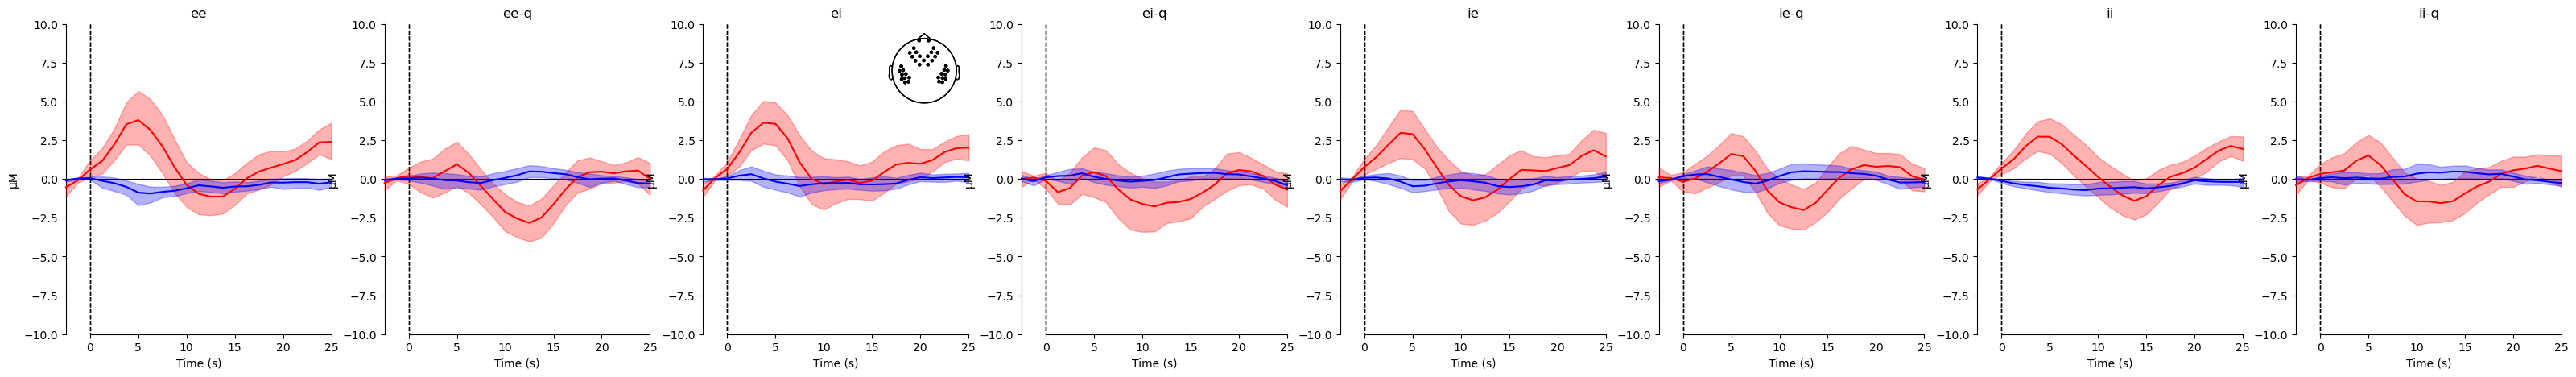

In [9]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(40, 5))
lims = dict(hbo=[-10, 10], hbr=[-10, 10])  # Set the scale limits for each chromophore

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        # Plot the average evoked response for each condition and chromophore
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                            picks=pick, axes=axes[idx], show=False,
                            colors=[color], legend=False, ylim=lims, ci=0.95,
                            show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))  # Set the title for each subplot

#axes[0].legend(leg_list, loc='lower right')  # Update the legend labels
plt.show()  # Display the plot

Plots Concentrations Across For Each Region and Trigger

More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
comb

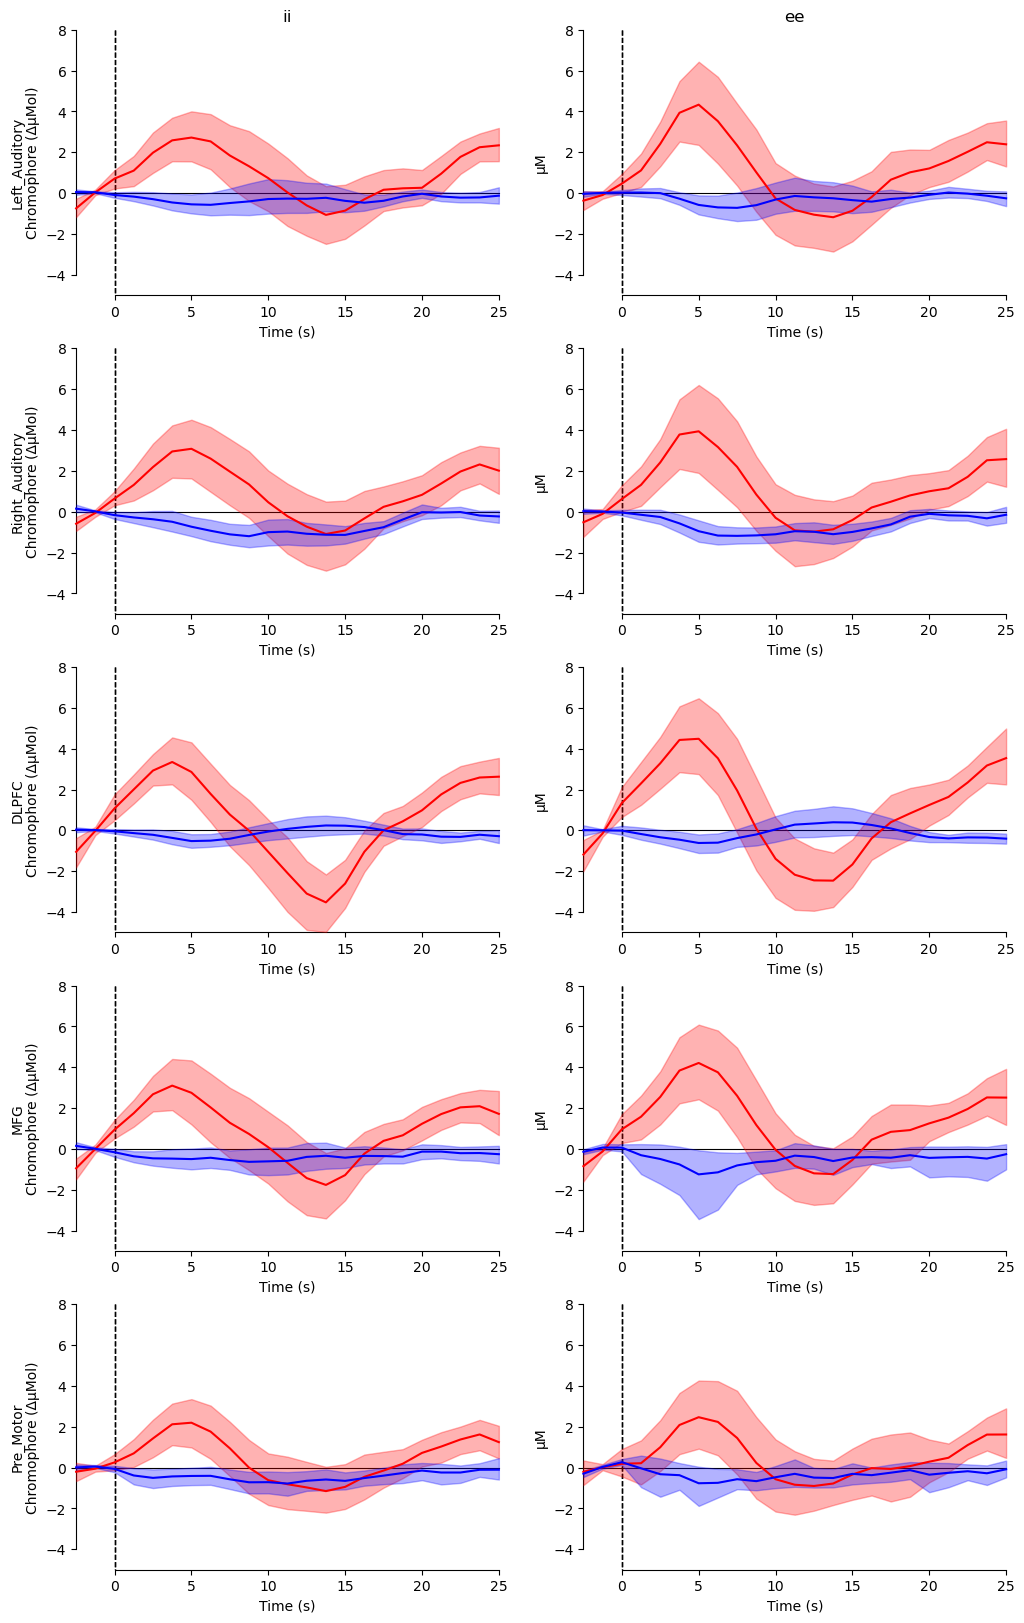

In [11]:
# # Adjust the code below to fit your unique ROIs
# # Specify the figure size and limits per chromophore.
# fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds),
#                         figsize=(40, 20))
# lims = dict(hbo=[-10, 10], hbr=[-10, 10])  # Set the scale limits for each chromophore

# for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
#     for ridx, roi in enumerate(rois):
#         for cidx, evoked in enumerate(all_evokeds):
#             if pick == 'hbr':
#                 picks = rois[roi][1::2]  # Select only the hbr channels
#             else:
#                 picks = rois[roi][0::2]  # Select only the hbo channels

#             # Plot the average evoked response for each condition and chromophore
#             plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
#                                 picks=picks, axes=axes[ridx, cidx],
#                                 show=False, colors=[color], legend=False,
#                                 ylim=lims, ci=0.95, show_sensors=cidx == 2)
#             axes[0, cidx].set_title(f"{evoked}")  # Set the title for the first row
#             axes[1, cidx].set_title("")  # Empty title for the second row
#             axes[2, cidx].set_title("")  # Empty title for the third row
#             axes[3, cidx].set_title("")  # Empty title for the fourth row
#             axes[4, cidx].set_title("")  # Empty title for the fifth row
#             #axes[5, cidx].set_title("")  # Empty title for the fifth row

#         axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")  # Set the y-label for each row

# #axes[0, 0].legend(leg_list)  # Add the legend
# plt.show()  # Display the plot


# Filter conditions to include only 'ee' and 'ii'
filtered_evokeds = {cond: all_evokeds[cond] for cond in ['ii', 'ee'] if cond in all_evokeds}

# Adjust the code below to fit your unique ROIs
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(filtered_evokeds),
                         figsize=(12, 20))
lims = dict(hbo=[-5, 8], hbr=[-5, 8])  # Set the scale limits for each chromophore

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, (cond, evoked) in enumerate(filtered_evokeds.items()):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            # Plot the average evoked response for each condition and chromophore
            plot_compare_evokeds({cond: evoked}, combine='mean',
                                 picks=picks, axes=axes[ridx, cidx],
                                 show=False, colors=[color], legend=False,
                                 ylim=lims, ci=0.95, show_sensors=cidx == 2)
            axes[0, cidx].set_title(f"{cond}")  # Set the title for the first row
            axes[1, cidx].set_title("")  # Empty title for the second row
            axes[2, cidx].set_title("")  # Empty title for the third row
            axes[3, cidx].set_title("")  # Empty title for the fourth row
            axes[4, cidx].set_title("")  # Empty title for the fifth row
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")  # Set the y-label for each row

plt.show()  # Display the plot

Print the Evoked Amplitude Data into the Console

In [67]:
# Print out the first entries in the dataframe
df.head()
pprint(df)

    ID        ROI Chroma Condition     Value
0    0      DLPFC    hbo        ee  2.457104
0    0      DLPFC    hbr        ee  0.356015
0    0        MFG    hbo        ee  1.690837
0    0        MFG    hbr        ee  0.712555
0    0  Pre_Motor    hbo        ee  2.644949
..  ..        ...    ...       ...       ...
0   27    Left_PT    hbr      ii-q -2.307280
0   27   Right_HG    hbo      ii-q  0.263703
0   27   Right_HG    hbr      ii-q  0.549404
0   27   Right_PT    hbo      ii-q  0.766294
0   27   Right_PT    hbr      ii-q -1.824068

[3136 rows x 5 columns]


Plot the Evoked Amplitude Data

In [68]:
LetsPlot.setup_html()

# Plots individual results by plotting evoked amplitudes for each trigger
ggplot(df.query("Chroma == 'hbo'"),
       aes(x='Condition', y='Value', color='ID', shape='ROI')) \
    + geom_hline(y_intercept=0, linetype="dashed", size=1) \
    + geom_point(size=5) \
    + scale_shape_manual(values=[16, 17]) \
    + ggsize(800, 300)

Compare Conditions

In [72]:
# Compare conditions within an ROI

# Filter input data based on conditions, chromophore, and ROI
input_data = df.query("Condition in ['ee', 'ii']")  # Filter conditions
input_data = input_data.query("Chroma in ['hbo']")  # Filter chromophore
input_data = input_data.query("ROI in ['Right_HG']")  # Filter ROI

# Fit mixed-effects model with groups based on ID
roi_model = smf.mixedlm("Value ~ Condition", input_data,
                        groups=input_data["ID"]).fit()

# Print the summary of the fitted model
pprint(roi_model.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Value    
No. Observations:  56       Method:              REML     
No. Groups:        28       Scale:               14.4980  
Min. group size:   2        Log-Likelihood:      -156.2760
Max. group size:   2        Converged:           Yes      
Mean group size:   2.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        2.837    0.781  3.631 0.000  1.306  4.368
Condition[T.ii] -0.209    1.018 -0.205 0.837 -2.203  1.786
Group Var        2.589    0.995                           

"""
